##  Using SAS DLPy to Create a Neural Network Model for Regression Using Tabular Data  

You can use SAS DLPy to  easily create and train a variety of basic task-oriented deep learning models. This notebook example shows how you can use SAS DLPy to build a fully-connected neural network regression model using tabular data. The model in this notebook uses tables of numeric values to perform a regression task: predict the price of a California home, based on eight housing attributes such as house age, location, average number of bedrooms, population, and so on. 

The clean tabular data used to create the model is the [Scikit-Learn California Housing data set](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset). The California housing data is a real world data set, a 20,640-observation table of 8 numeric, predictive attributes and the target. The target variable is the median house value for California districts. The scikit-Learn data set was derived from the public 1990 U.S. census, using one row per census block group. (A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data). The public data set was obtained from [Carnegie Mellon's StatLib repository](http://lib.stat.cmu.edu/datasets/). More technical information about the composition and use of the Scikit-learn California housing data [is available here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

The learning objective of this notebook is to understand how to use SAS DLPy to create a fully-connected neural network model designed to perform a tabular data regression task, and how to use model performance plots to assess the model's predictive robustness. 

The notebook follows these steps: 

- Configure SAS DLPy and SAS CAS environments for this task.
- Upload the California housing data to the SAS CAS server.
- Create train and test data sets in SAS CAS.
- Use SAS DLPy to build a fully-connected neural network regression model.
- Train the fully-connected neural network model.
- Evaluate the model training loss statistics.
- Use the trained model to score the test data set.
- Evaluate the scored test data result statistics.

This tutorial example assumes that you have SAS DLPy API installed, have an active SAS CAS server, and have installed the common Python utilities used in the code (numpy, sklearn, matplotlib, Pandas).

### Table of Contents 
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Import Required Python and SAS DLPy Utilities](#importPythonDLPy)
- [Configure SAS SWAT and Launch SAS CAS](#launchCAS)
- [Load the Example Data](#loadData)
    - [Partition into Train and Test Data](#partitionData)
- [Use DLPy to Create a Neural Network Model](#createModel)
- [Train the Neural Network Regression Model](#trainModel)
- [Evaluate the Training Loss](#Plots)    
    - [Mean Squared Error](#MSE)
    - [Mean Absolute Error](#MAE)
    - [Explained Variance Score](#explained)
- [Score the Test Data](#scoreModel)
    - [Mean Squared Error](#MSE2)
    - [Mean Absolute Error](#MAE2)
    - [Explained Variance Score](#explained2)
- [Summary](#summary)    


<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and to configure your local computing environment in advance. This enables you to follow along with the example notebook modeling operations without interruption. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Utilities

Import the Python and SAS DLPy utilities required for the model task. They include the scikit-Learn utility, the pandas data analysis library, the numPy scientific computing library, and the matplotlib plotting utility.

In [1]:
# Pandas data analysis utility
import pandas as pd

# NumPy scientific computing utility
import numpy as np

# Matplotlib plotting utility
import matplotlib.pylab as plt

# SAS DLPy model utilities
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import *

# Display output plots in notebook cells
%matplotlib inline

# Import scikit-Learn utility
import sklearn

# Import SAS SWAT
import swat
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# SAS DLPy utility modules
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import explained_variance_score, mean_squared_error, mean_absolute_error
%matplotlib inline

<a id="launchCAS"></a>

### Configure SAS SWAT and Launch SAS CAS

The following code configures SAS SWAT and launches SAS CAS. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data.

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
# Configure CAS session for Analytics
s = CAS('your-host-name.unx.company-name.com', 5570)

<a id="loadData"></a>

### Load the Example Data

Use the code block below to import the scikit-Learn real-world California housing diagnostic data set, create pandas predictor and target dataframes, and then merge the two dataframes. Browse the concatenated pandas table before loading it into SAS CAS.

In [3]:
# Import California Housing data into SAS CAS
# and save the CAS table as california_housing.
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

# Put the california_housing contents into two pandas dataframes: 

# One dataframe for the predictors (ch_x_df). 
ch_x_df = pd.DataFrame(california_housing['data'], 
                       columns=california_housing['feature_names']
                       )

# One dataframe for the target (ch_y_df). 
ch_y_df = pd.DataFrame(california_housing['target'], 
                       columns=['house_value']
                       )

# Concatenate the predictor and target dataframes 
# into one dataframe with 8 feature columns and 
# 1 target column.
ch_df = pd.concat([ch_x_df, ch_y_df], axis=1)

In [4]:
# Browse the concatenated pandas housing data.
# Display column headings and 11 rows from the table.
ch_df.loc[:10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In the table above, the rightmost column `house_value` represents the median house value for the observation's census block group. 

Use the `upload_frame()` function with the concatenated table `ch_df` to load the pandas dataframe to the server. The CAS table `ch_df` is loaded and saved in Python as `tbl`.

In [5]:
tbl = s.upload_frame(ch_df, 
                     casout=dict(name='ch_df', 
                                 replace=True
                                 )
                     );

NOTE: Cloud Analytic Services made the uploaded file available as table CH_DF in caslib CASUSER(UserID).
NOTE: The table CH_DF has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


<a id="partitionData"></a>

### Partition into Train and Test Data

Split the loaded California housing table `tbl` into train and test partitions. Use the DLPy `two_way_split` function to perform random server-side sampling and partition the data into `train_tbl` and `test_tbl`. Server-side partitioning is preferable to client-side partitioning when the data is large, or when the data is already on the server. 

The code below partitions 80% of `tbl` into `train_tbl`, and the remaining 20% is partitioned as `test_tbl`. The `seed` value is specified to ensure repeatability of example computation results.

In [6]:
# Partition tbl into train and test data sets
train_tbl, test_tbl = two_way_split(tbl, 
                                    # 20% test partition 
                                    test_rate=20, 
                                    # random seed value
                                    seed=123, 
                                    # use random sampling 
                                    stratify=False, 
                                    # using tabular numeric data,
                                    # not an image table 
                                    im_table=False)

In [7]:
# Display five rows from the 
# newly created train table.
train_tbl.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value
0,2.1923,52.0,3.010676,0.964413,1153.0,4.103203,34.04,-118.21,1.550
1,1.9402,43.0,2.819071,1.004890,1667.0,4.075795,34.05,-118.22,1.393
2,2.5455,47.0,3.194690,1.039823,930.0,4.115044,34.05,-118.21,1.143
3,1.2000,44.0,2.970430,0.930108,1598.0,4.295699,34.05,-118.22,1.156
4,1.5163,43.0,3.314003,1.135785,2468.0,3.490806,34.04,-118.22,1.150


In [8]:
# Display five rows from the 
# newly created test table.
test_tbl.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value
0,3.5240,45.0,5.213964,1.015766,1006.0,2.265766,37.72,-122.13,1.862
1,3.9032,19.0,5.001422,1.009957,1810.0,2.574680,37.70,-122.13,2.180
2,3.3950,17.0,3.701400,1.195956,1216.0,1.891135,37.69,-122.13,2.713
3,3.9702,36.0,5.297071,0.953975,606.0,2.535565,37.70,-122.14,1.941
4,3.6625,38.0,5.612613,0.995495,637.0,2.869369,37.69,-122.15,1.846


<a id="createModel"></a>

### Use SAS DLPy to Create a Fully-Connected Neural Network Model

Use SAS DLPy to create a fully-connected neural network regression model with the following architecture: 

 - One input layer
 - Two dense layers
 - 30 neurons in first dense layer 
 - 10 neurons in the second dense layer
 - `relu` activation layer
 - `identity` output layer activation function
 - `normal error (squared loss)` output layer loss function 

Save the newly created neural network regression model in Python as `model1`, and save the model table in SAS CAS as `Simple_DNN1`.

In [9]:
# Create fully-connected deep neural network 'model1'
model1 = Sequential(s, 
                    model_table='Simple_DNN1'
                    )

# Input layer
model1.add(InputLayer(std='STD')
           )

# Dense Layer
model1.add(Dense(30, act='relu')
           )
model1.add(Dense(10, act='relu')
          )

# Output layer
model1.add(OutputLayer(act='identity', 
                       error='normal'
                       )
           ) 

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


As an additional exercise, uncomment the bottom line of the code below, and run the cell to generate a DAG of `model1`.

In [ ]:
# Generate a DAG for the neural 
# network regression model.

# model1.plot_network()

The generated DAG for the simple neural network regression model should resemble the following:

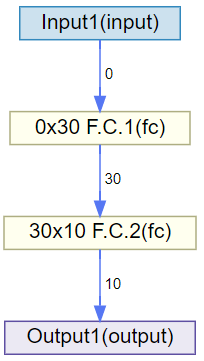

<a id="trainModel"></a>

### Train the Neural Network Regression Model

Now use `fit()` with `model1` to train the fully-connected neural network model using a scheduled training approach with the following hyperparameter specifications:

- `AdamSolver` optimizer to show a scheduled training approach using polynomial decay.
- `learning_rate_policy='poly'` to specify the polynomial learning rate decreasing policy.
- `power=1`, for the learning rate function $initial\_learning\_rate*(1 - \frac{epoch}{max\_epochs})^{power}$.
- `log_level=2` to view the training log
- `seed=1234` to support model determinism and repeatable results.

Save the trained model table in Python as `result`.

In [10]:
# Specify optimizer settings for scheduled training approach
# These optimizer settings are called in the fit() block that 
# follows.
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.02, 
                                           learning_rate_policy='poly', 
                                           power=1
                                           ),
                      mini_batch_size=4, 
                      seed=1234, 
                      max_epochs=50, 
                      log_level=2
                      )

# Train the model model1 using 
# data train_tbl, and save the  
# trained output table as 'result' 
result = model1.fit(train_tbl, 
                    # predictor columns
                    inputs=ch_x_df.columns.tolist(), 
                    # target column
                    target='house_value', 
                    # optimizer settings
                    optimizer=optimizer
                    )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 591.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.02 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The maximum mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: house_value
NOTE:  Number of input variables:     8
NOTE:  Number of numeric input variables:      8
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.02          0.3797     0.7593     0.04
NOTE:  1        0.0196          0.2016     0.4032     0.03
NOTE:  2        0.0192          0.1899     0.3797     0.03
NOTE:  3        0.0188          0.1726     0.3452     0.03
NOTE:  4        0.0184          0.1735      0.347     0.03
....  ...       ......          ......     ......     .

Use the matplotlib function `plot_training_history()` with `model1` to display a graph of the model's training over 50 epochs:

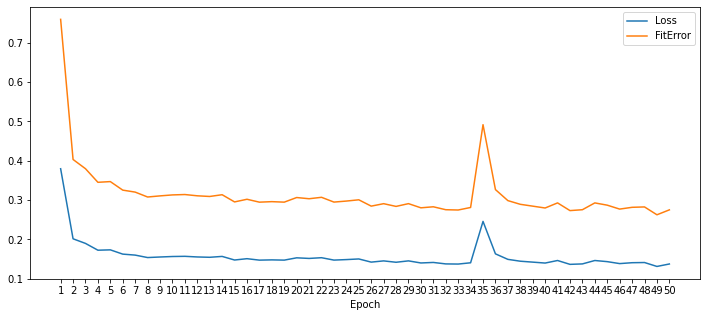

In [11]:
# Plot the training history of 'model1' to
# display the changing model loss and fit 
# error values over 50 epochs.
model1.plot_training_history()

<a id="Plots"></a>

### Score the Training Data to Evaluate Training Loss

After training for the model `model1`, let us examine the training losses. Use the `predict()` function for `model1` with `train_tbl` to score the training data for model fit evaluation. Save the scored CAS data in `model1.valid_res_tbl` in Python as `fitted_table`.

In [12]:
# Score the model1 train table train_tbl
# Save to Python as fitted_result
fitted_result = model1.predict(train_tbl)

# Save the CAS table with scored train 
# results as fitted_table.
fitted_table = model1.valid_res_tbl

# Display the ScoreInfo summary data  
# for the scored train data set.
print(fitted_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read         16512
1  Number of Observations Used         16512
2           Mean Squared Error      0.274608
3                   Loss Error      0.137304


Use the `head()` function to show the first five rows of the scored train table `fitted_table`.

In [13]:
# Display the first five rows of
# the scored train data set.
fitted_table.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value,P_house_value
0,2.1923,52.0,3.010676,0.964413,1153.0,4.103203,34.04,-118.21,1.550,1.310263
1,1.9402,43.0,2.819071,1.004890,1667.0,4.075795,34.05,-118.22,1.393,1.479430
2,2.5455,47.0,3.194690,1.039823,930.0,4.115044,34.05,-118.21,1.143,1.422569
3,1.2000,44.0,2.970430,0.930108,1598.0,4.295699,34.05,-118.22,1.156,0.988461
4,1.5163,43.0,3.314003,1.135785,2468.0,3.490806,34.04,-118.22,1.150,1.740667


<a id="MSE"></a>

#### Mean Squared Error

We can use the scored train data set to evaluate the model performance metrics.  For example, we can calculate the MSE. Mean squared error is calculated as the average squared difference between the actual value and the estimated (scored) values. The MSE statistic measures the quality of a predictive estimator.

Use the SAS DLPy `mean_squared_error()` function with the table `fitted_table` to compare the MSE between the ground truth `house_value` and the trained model's predicted `P_house_value`. MSE values closer to 0 are preferred.

In [14]:
# Evaluate the MSE using 
# dlpy.metrics.mean_squared_error
mse = mean_squared_error(fitted_table['house_value'], 
                         fitted_table['P_house_value']
                         )
print('The Mean Squared Error for the scored train data is {:.6f}.'.format(mse))

The Mean Squared Error for the scored train data is 0.274608.


<a id="MAE"></a>

#### Mean Absolute Error

We can also use the scored data set to calculate another model accuracy measure, the MAE (Mean Absolute Error) statistic. The MAE is the mean of all absolute errors.  

Use the SAS DLPy `mean_absolute_error()` function with the table `fitted_table` to compare the MAE between the ground truth `house_value` and the trained model's predicted `P_house_value`. MAE values closer to 0 are preferred.

In [15]:
# Evaluate the MAE using 
# dlpy.metrics.mean_absolute_error
mae = mean_absolute_error(fitted_table['house_value'], 
                          fitted_table['P_house_value']
                          )
print('The Mean Absolute Error for the scored train data is {:.6f}.'.format(mae))

The Mean Absolute Error for the scored train data is 0.360361.


<a id="explained"></a>

#### Explained Variance Score

Finally, we can use the scored data and the explained variance score to measure the predictive model accuracy. Explained variance indicates the discrepancy between the ground truth and the predicted values. The explained variance score statistic describes the part of the model's total variance that can be explained by factors that are present, as opposed to differences due to error variance.  Values closer to 0 are bad and values closest to 1 are desirable. 

Use the SAS DLPy `explained_variance_score()` function with the table `fitted_table` to examine the explained variance between the ground truth `house_value` and the trained model's predicted `P_house_value`. Explained variance percentages close to 0 are undesirable, percentages closest to 100 are desirable. 

In [16]:
# Evaluate the explained variance score 
# using dlpy.metrics.explained_variance_score
evs = explained_variance_score(fitted_table['house_value'], 
                               fitted_table['P_house_value']
                               )
print('{:.2f}% of the target variable variance in the scored train data '.format(evs*100))
print('can be explained by the model.')

79.53% of the target variable variance in the scored train data 
can be explained by the model.


<a id="scoreModel"></a>

### Score the Test Data Using Trained Neural Network Model

Now use the `predict()` function for `model1` with `test_tbl` to score the test data. Save the scored data in `model1.valid_res_tbl` in Python as `test_result_table`.

In [17]:
# Use model1 to score the test data test_tbl.
test_result = model1.predict(test_tbl)

# Save the scored data table as test_result_table.
test_result_table  = model1.valid_res_tbl

# Display the ScoreInfo summary data  
# for the scored test data set.
print(test_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read          4128
1  Number of Observations Used          4128
2           Mean Squared Error      0.275125
3                   Loss Error      0.137563


In [18]:
# Display 5 sample rows from the scored
# test data set result table.
test_result_table.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value,P_house_value
0,3.5240,45.0,5.213964,1.015766,1006.0,2.265766,37.72,-122.13,1.862,2.371657
1,3.9032,19.0,5.001422,1.009957,1810.0,2.574680,37.70,-122.13,2.180,2.116483
2,3.3950,17.0,3.701400,1.195956,1216.0,1.891135,37.69,-122.13,2.713,2.139857
3,3.9702,36.0,5.297071,0.953975,606.0,2.535565,37.70,-122.14,1.941,1.932699
4,3.6625,38.0,5.612613,0.995495,637.0,2.869369,37.69,-122.15,1.846,1.830478


<a id="MSE2"></a>

#### Mean Squared Error

Now we can use the scored test data set to evaluate the model performance metrics.  For example, we can calculate the MSE (Mean Squared Error), the average squared difference between the estimated (scored) values and the ground truth value. The MSE statistic measures the quality of a model predictor. 

Use the SAS DLPy `mean_squared_error()` function with the table `test_result_table` to compare the MSE between the ground truth `house_value` and the trained model's predicted `P_house_value`. MSE values closer to 0 are desirable.

In [19]:
# Evaluate the MSE using 
# dlpy.metrics.mean_squared_error
mse = mean_squared_error(test_result_table['house_value'], 
                         test_result_table['P_house_value']
                         )
print('The Mean Squared Error for the scored test data is {:.6f}.'.format(mse))

The Mean Squared Error for the scored test data is 0.275125.


<a id="MAE2"></a>

#### Mean Absolute Error

We can also use the scored test data set to calculate the MAE (Mean Absolute Error) statistic. The MAE is the mean of all absolute errors in the scored data. A MAE score close to 0 is desirable.  

Use the SAS DLPy `mean_absolute_error()` function with the table `test_result_table` to compare the MAE between the ground truth `house_value` and the trained model's predicted `P_house_value`. MAE values closer to 0 are desirable.

In [20]:
# Evaluate the MAE using dlpy.metrics.mean_absolute_error
mae = mean_absolute_error(test_result_table['house_value'], 
                          test_result_table['P_house_value']
                          )
print('The Mean Absolute Error for the scored test data is {:.6f}.'.format(mae))

The Mean Absolute Error for the scored test data is 0.364937.


<a id="explained2"></a>

#### Explained Variance Score

Finally, we can use the scored data and the explained variance score to measure the predictive model accuracy. Explained variance examines the discrepancy between the ground truth and the predicted values. The explained variance score describes the portion of the model's total variance that can be explained by existing model factors, as opposed to differences due to error variance.  Explained variance percentage values close to 0 are undesirable, percentage values close to 100% are desirable. 

Use the SAS DLPy `explained_variance_score()` function with the test results table to analyze explained variance for predicted house values versus ground truth house values. The greater the percentage of explained variance, the less randomness there is in the model predictions.

In [21]:
# Evaluate the model's explained variance  
# using dlpy.metrics.explained_variance_score
evs = explained_variance_score(test_result_table['house_value'], 
                               test_result_table['P_house_value']
                               )
print('{:.2f}% of the target variable variance in the scored test data'.format(evs*100))
print('can be explained by the model.')

78.76% of the target variable variance in the scored test data
can be explained by the model.


<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed how to use SAS DLPy to create a fully-connected neural network model for a regression task using tabular data. It showed how to use DLPy to score data with a trained model, and it also showed how to use DLPy to generate and view multiple performance metrics (MSE, MAE, and Explained Variance) using scored data table output from the trained neural network model.